In [1]:
# Import libraries

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, assemble, transpile
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit import IBMQ, Aer
from qiskit.quantum_info import Statevector, partial_trace, random_unitary
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from numpy.random import randint, rand
from IPython.display import clear_output
from qiskit.extensions import Initialize
from statistics import mean, stdev, variance
from qiskit.providers.aer.noise import NoiseModel, device
from qiskit.providers.aer import QasmSimulator
import qiskit
from qiskit.test.ibmq_mock import mock_get_backend
from mitiq import zne
import matplotlib.pyplot as plt
import numpy as np
from math import pi, sqrt
import time
from random import choice, sample
IBMQ.save_account('bdde1c124342f5707b2cb22a03b9facf9d5ec281af7160895d0c1bc976438f056becb5a303f7adbf320d11f09e5e7512d7885c1a09c5df9f34804f09e7a49527',overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
shots = 1024
sim = provider.get_backend('ibmq_qasm_simulator')
backend = provider.get_backend('ibmq_lima')
state_vector_sim = Aer.get_backend('statevector_simulator')

<ipython-input-1-0865366a41b2>:7: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
WARNING - Retrying (PostForcelistRetry(total=4, connect=3, read=None, redirect=None, status=None)) after connection broken by 'ProtocolError('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))': /api/users/me


In [2]:
#Building Noise Model
backend = provider.get_backend('ibmq_lima')

# Build noise model from backend properties
noise_model = NoiseModel.from_backend(backend)
# Get coupling map from backend
coupling_map = backend.configuration().coupling_map
# Get basis gates from noise model
basis_gates = noise_model.basis_gates

actualbackend_properties = backend.properties()
readout_errors = device.basic_device_readout_errors(actualbackend_properties)
gate_errors = device.basic_device_gate_errors(actualbackend_properties)
error_values = device.readout_error_values(actualbackend_properties)
gate_param_values = device.gate_param_values(actualbackend_properties)
gate_error_values = device.gate_error_values(actualbackend_properties)
gate_length_values = device.gate_length_values(actualbackend_properties)
thermal_relaxation_values = device.thermal_relaxation_values(actualbackend_properties)

created_noise_model = NoiseModel()
for qubit, error in readout_errors:
    created_noise_model.add_readout_error(error, qubit)
for instr, qubit, error in gate_errors:
    created_noise_model.add_quantum_error(error, instr, qubit)
created_noisy_sim = QasmSimulator(noise_model = created_noise_model)

In [3]:
#function to create pure entangled states

def pure_estate(circuit,q0,q1):
    u1 = random_unitary(2)
    circuit.append(u1,[q0])
    circuit.cx(q0,q1)
    
    return circuit       

In [4]:
###### Generating a random message

n=int(input("Length of message:"))
message = np.random.randint(2, size = n)
print(message)
nd=int(input("Number of decoy bits to be inserted:"))

Length of message:15
[0 1 1 1 0 1 0 1 0 1 0 1 1 0 0]
Number of decoy bits to be inserted:10


In [5]:
#Generating a list of possible states

states=['0', '1', '+', '-']

In [6]:
#Generating set of decoy photons

dq_st=[]
def gen_decoy(i):
    dqu=QuantumCircuit(1,1)
    if i=='1' or i=='-':
        dqu.x(0)
    if i=='+' or i=='-':
        dqu.h(0)
    return dqu
    #dqu.save_statevetor()
    #dq.append(dqu)
    #result = state_vector_sim.run(dqu).result()
    #sv = result.get_statevector()
    #dq_st.append(sv)

In [7]:
#Step1:Creating n pure entangled states
def create_pest(m):
    pk=[]
    for i in range(m):
        qr = QuantumRegister(2, 'qb')
        cr = ClassicalRegister(1, 'cb')
        circuit = QuantumCircuit(qr,cr)
        state=(pure_estate(circuit,qr[0],qr[1]))
        pk.append(state)
        #display(pk[i].draw('mpl'))
    return pk

private_key0=create_pest(n)
#check eavesdropping by adding decoy photons at random position and printing the positions

def create_pkd(private_key,n,nd):
    pkd=[]
    for i in range(n):
        pkd.append(private_key[i].copy())
    lst=[x for x in range(n+nd)]
    pos1=sample(lst,nd)
    pos1.sort()
    rdq1=[]
    rdq_st1=[]
    for i in pos1:
        decoy_st1=choice(states)
        decoy1=gen_decoy(decoy_st1)
        rdq1.append(decoy1)
        rdq_st1.append(decoy_st1)
        decoy12=decoy1.copy()
        pkd.insert(i,decoy12)
    print(pos1)
    return pkd,rdq_st1,pos1

pkd0,rdq_st10,pos10=create_pkd(private_key0,n,nd)

[0, 1, 6, 7, 13, 14, 15, 16, 19, 20]


In [8]:
#for i in range(nd):
    #result = state_vector_sim.run(rdq1[i]).result()
    #sv = result.get_statevector()
    #print(sv)
for i in range(nd):
    print(rdq_st10[i])

0
0
0
1
-
-
+
-
+
-


In [9]:
#Measuring the decoy photons inserted in sequence of pure entangled states in respective bases and finiding the errors

errors_for_first_check0=[]
errors_count_for_first_check0=[]
def check_eavesdropper1(pkd,rdq_st1,errors_for_first_check0,errors_count_for_first_check0,pos1):
    j=0
    err1=0
    err_rate1=0.0
    err_count1=0
    err_count_rate1=0.0
    time01 = time.time()
    for i in pos1:
        flag=0
        if rdq_st1[j]=='+' or rdq_st1[j]=='-':
            pkd[i].h(0)
            flag=1
        pkd[i].measure(0,0)
        rslt1 = execute(pkd[i], backend=created_noisy_sim, shots=shots).result()
        cc1 = rslt1.get_counts()
        k=list(cc1.keys())
        k.sort()
        #display(pkd[i].draw('mpl'))
        #print("The measurements of the decoy photon at position",i,"after the attack is:",cc1)       
        if '0' and '1' not in k:
            err1=1024
        if flag == 0:
            if k[0] == rdq_st1[j]:
                err1=cc1['1']
                if cc1['1']>cc1['0'] or abs(cc1['0']-cc1['1'])<600:
                    err_count1 += 1
            elif k[1] == rdq_st1[j]:
                err1 = cc1['0']
                if cc1['0']>cc1['1'] or abs(cc1['0']-cc1['1'])<600:
                    err_count1 += 1
        elif flag==1:
            if rdq_st1[j]=='+':
                err1=cc1['1']
                if abs(cc1['0']-cc1['1'])<600:
                    err_count1 += 1
            elif rdq_st1[j]=='-':
                err1=cc1['0']
                if abs(cc1['0']-cc1['1'])<600:
                    err_count1 += 1
        j=j+1
        err_rate1=err_rate1+float((err1/shots)*100)
    time_1 = time.time() - time01
    hr1 = time_1//3600
    time_1 %= 3600
    err_rate1=float(err_rate1/nd)
    err_count_rate1=float((err_count1/nd)*100)
    errors_for_first_check0.append(err_rate1)
    errors_count_for_first_check0.append(err_count_rate1)
    return err_count1,err_count_rate1,err_rate1,hr1,time_1

err_count1,err_count_rate1,err_rate1,hr1,time_1=check_eavesdropper1(pkd0,rdq_st10,errors_for_first_check0,errors_count_for_first_check0,pos10)
print(f"Error rate in measuring decoy photons: {err_rate1} %")
print(f"The number of mismatched decoy photons is {err_count1} and the error rate of trasmitting decoy photons: {err_count_rate1} %")
print(f'Time taken to measure {nd} decoy photons: {int(hr1)} hours {int(time_1//60)} minutes {time_1%60} seconds')
if err_count1!=0:
    print("\nEavesdropper detected.")
else:
    print("\nNo Eavesdropper detected.")

Error rate in measuring decoy photons: 3.193359375 %
The number of mismatched decoy photons is 0 and the error rate of trasmitting decoy photons: 0.0 %
Time taken to measure 10 decoy photons: 0 hours 0 minutes 1.2596280574798584 seconds

No Eavesdropper detected.


In [10]:
#Step2:Creating a sequence of travelling qubits in Z basis

def create_tq(msg):
    tt=[]
    for i in msg:
        t=QuantumCircuit(QuantumRegister(1))
        if i==0:
            tt.append(t)
        else:
            t.x(0)
            tt.append(t)
    return tt


tq0=create_tq(message)        

In [11]:
#Step3: Encrypting the message using CNOT gate

def encrypt_mes(pk,tt,m):
    for i in range(m):       
        pk[i].add_register(*tt[i].qregs)
        pk[i].barrier()
        pk[i]=pk[i]+tt[i]
        #display(pk[i].draw('mpl'))
        pk[i].cx(0,2)
        

encrypt_mes(private_key0,tq0,n)


#inserting decoy photons in the sequence of travelling photons to check for eavesdropping
def insert_decoys2(private_key,nd):
    rdq_st2=[]
    lst=[x for x in range(n+nd)]
    pos2=sample(lst,nd)
    pos2.sort()
    rdq2=[]
    for i in pos2:
        decoy_st2=choice(states)
        decoy2=gen_decoy(decoy_st2)
        rdq2.append(decoy2)
        rdq_st2.append(decoy_st2)
        decoy22=decoy2.copy()
        private_key.insert(i,decoy22)
    print(pos2)
    return private_key,rdq_st2,pos2

private_key0,rdq_st20,pos20=insert_decoys2(private_key0,nd)

[0, 2, 3, 8, 11, 13, 17, 18, 22, 23]


<ipython-input-11-1da6b4dc2c54>:7: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  pk[i]=pk[i]+tt[i]


In [12]:
for i in range(nd):
    print(rdq_st20[i])

+
+
0
+
1
-
+
+
0
+


In [13]:
#Measuring the decoy photons inserted in sequence of travelling photons in respective bases and finiding the errors

errors_for_second_check0=[]
def check_eavesdropper2(pk,rdq_st2,errors_for_second_check,pos2):
    j=0
    err2=0
    err_rate2=0.0
    err_count2=0
    err_count_rate2=0.0
    time02 = time.time()
    for i in pos2:
        flag=0
        if rdq_st2[j]=='+' or rdq_st2[j]=='-':
            pk[i].h(0)
            flag=1
        pk[i].measure(0,0)
        rslt2 = execute(pk[i], backend=created_noisy_sim, shots=shots).result()
        cc2 = rslt2.get_counts()
        m=list(cc2.keys())
        m.sort()
        #display(pk[i].draw('mpl'))
        #print("The measurements of the decoy photon at position",i,"after the attack is:",cc2)       
        if '0' and '1' not in m:
            err2=1024
        if flag == 0:
            if m[0] == rdq_st2[j]:
                err2=cc2['1']
                if cc2['1']>cc2['0'] or abs(cc2['0']-cc2['1'])<500:
                    err_count2 += 1
            elif m[1] == rdq_st2[j]:
                err2 = cc2['0']
                if cc2['0']>cc2['1'] or abs(cc2['0']-cc2['1'])<500:
                    err_count2 += 1            
        elif flag==1:
            if rdq_st2[j]=='+':
                err2=cc2['1']
                if abs(cc2['0']-cc2['1'])<500:
                    err_count2 += 1
            elif rdq_st2[j]=='-':
                err2=cc2['0']
                if abs(cc2['0']-cc2['1'])<500:
                    err_count2 += 1
        j=j+1
        err_rate2=err_rate2+float((err2/shots)*100)
    time_2 = time.time() - time02
    hr2 = time_2//3600
    time_2 %= 3600
    err_rate2=float(err_rate2/nd)
    err_count_rate2=float((err_count2/nd)*100)
    errors_for_second_check.append(err_rate2)
    return err_count2,err_count_rate2,err_rate2,hr2,time_2

err_count2,err_count_rate2,err_rate2,hr2,time_2=check_eavesdropper2(private_key0,rdq_st20,errors_for_second_check0,pos20)
print(f"Error rate in measuring decoy photons: {err_rate2} %")
print(f"The number of mismatched decoy photons is {err_count2} and the error rate of trasmitting decoy photons: {err_count_rate2} %")
print(f'Time taken to measure {nd} decoy photons: {int(hr2)} hours {int(time_2//60)} minutes {time_2%60} seconds')
if err_count2!=0:
    print("\nEavesdropper detected.")
else:
    print("\nNo Eavesdropper detected.")

Error rate in measuring decoy photons: 2.138671875 %
The number of mismatched decoy photons is 0 and the error rate of trasmitting decoy photons: 0.0 %
Time taken to measure 10 decoy photons: 0 hours 0 minutes 1.0581674575805664 seconds

No Eavesdropper detected.


In [14]:
#Step 4: Decrypting the message using CNOT gate

def decrypt_mes(pk,m,pos2):
    for i in range(m):
        if i not in pos2:
            pk[i].cx(1,2)
            pk[i].barrier()
            #display(pk[i].draw('mpl'))
        
decrypt_mes(private_key0,n+nd,pos20)

In [15]:
def cal_error_and_res(fm,mssg,j,error_in_mssg):
    error=0
    a=list(fm.keys())
    a.sort()
    res=-1
    if '0' in fm and '1' not in fm:
        res=0
    elif '1' in fm and '0' not in fm:
        res=1
    if '0' in fm and '1' in fm:
        if fm['0']>fm['1'] and abs(fm['0']-fm['1'])>600:
            res=0
        elif fm['0']<fm['1'] and abs(fm['0']-fm['1'])>600:
            res=1
        if int(a[0])==mssg[j]:
            error=fm['1']
        elif int(a[1])==mssg[j]:
            error=fm['0']
    if res!=mssg[j]:
        error_in_mssg+=1
    return res,error

In [16]:
def mitigate_gateerror(circuit,count_qubits,message):
    lambda_v = list(range(1,7,2))
    expected_v=[]
    for l in lambda_v:
        qr2=QuantumRegister(3)
        cr2=ClassicalRegister(1)
        qc_noise = QuantumCircuit(qr2,cr2)
        qc_noise.append(circuit, qargs=[0,1,2], cargs = [0])
        d = qc_noise.depth()
        k = d*(l-1)/2
        n = int(k/d)
        s = k%d
        for _ in range(n):
            qc_noise.append(circuit.inverse(), qargs=[0,1,2], cargs = [0] ) 
            qc_noise.barrier()
            qc_noise.append(circuit, qargs=[0,1,2], cargs = [0])
            qc_noise.barrier()
        qc_noise.measure([2], [0])
        results = execute(qc_noise, backend = created_noisy_sim, shots=shots, optimisation_level = 0).result()
        counts= results.get_counts()
        expected_value=counts[str(message)]/shots
        expected_v.append(expected_value)
    model = np.polyfit(lambda_v, expected_v, 2)
    final_value = model[-1]
    final_count = final_value * shots
    if (final_value>1):
        final_value = 1
    final_count = round(final_value * shots)
    #final_counts = {message: final_count}
    #print(final_counts)
    if (message == 0):
        final_counts = {str(message): final_count, "1": shots - final_count}
        #exp_counts["1"] = 0
    else:
        final_counts = {str(message): final_count, "0": shots - final_count}
        #exp_counts["0"] = 0
    return final_counts


Noisy counts are: {'0': 1003, '1': 21}
Mitigated counts are: {'0': 1024, '1': 0}
Noisy counts are: {'1': 964, '0': 60}
Mitigated counts are: {'1': 987, '0': 37}
Noisy counts are: {'1': 956, '0': 68}
Mitigated counts are: {'1': 953, '0': 71}
Noisy counts are: {'1': 949, '0': 75}
Mitigated counts are: {'1': 952, '0': 72}
Noisy counts are: {'0': 1012, '1': 12}
Mitigated counts are: {'0': 1024, '1': 0}
Noisy counts are: {'1': 955, '0': 69}
Mitigated counts are: {'1': 983, '0': 41}
Noisy counts are: {'0': 1007, '1': 17}
Mitigated counts are: {'0': 1016, '1': 8}
Noisy counts are: {'1': 927, '0': 97}
Mitigated counts are: {'1': 943, '0': 81}
Noisy counts are: {'0': 1000, '1': 24}
Mitigated counts are: {'0': 1024, '1': 0}
Noisy counts are: {'1': 964, '0': 60}
Mitigated counts are: {'1': 1000, '0': 24}
Noisy counts are: {'0': 1008, '1': 16}
Mitigated counts are: {'0': 1024, '1': 0}
Noisy counts are: {'1': 949, '0': 75}
Mitigated counts are: {'1': 986, '0': 38}
Noisy counts are: {'1': 948, '0': 

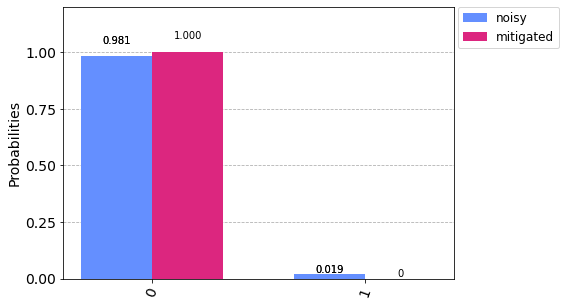

In [17]:
#Measuring the travelling qubit in Z basis

error_lst=[]
errors_in_mssg=[]
m_error_lst=[]
def measure_tq(pk,error_lst,errors_in_mssg,mssg,pos2):
    error=m_error=0
    error_rate=m_error_rate=0.0
    error_in_mssg=m_error_in_mssg=0
    error_in_mssg_rate=m_error_in_mssg_rate=0.0
    result2=[]
    m_result2=[]
    time03 = time.time()
    j=0
    for i in range(n+nd):
        if i not in pos2:            
            mitigated_counts=mitigate_gateerror(pk[i],1,mssg[j])
            pk[i].measure(2,0)
            result = execute(pk[i], backend=created_noisy_sim, shots=shots).result()
            noisy_counts=result.get_counts()
            print("Noisy counts are:",noisy_counts)
            print("Mitigated counts are:",mitigated_counts)        
            res,error=cal_error_and_res(noisy_counts,mssg,j,error_in_mssg)
            m_res,m_error=cal_error_and_res(mitigated_counts,mssg,j,error_in_mssg)
            error_rate = error_rate + float((error/shots)*100)
            m_error_rate = m_error_rate + float((m_error/shots)*100)
            result2.append(res)
            m_result2.append(m_res)
            #display(private_key[i].draw('mpl'))
            j+=1
    time_3 = time.time() - time03
    hr3 = time_3//3600
    time_3 %= 3600
    error_in_mssg_rate=float((error_in_mssg/n)*100)
    error_rate = float(error_rate/n)
    error_lst.append(error_rate)
    errors_in_mssg.append(error_in_mssg_rate)
    m_error_rate = float(m_error_rate/n)
    m_error_lst.append(m_error_rate)
    print(f"Amount of message bits received incorrectly: {error_in_mssg_rate} %")
    print(f"Error rate in measuring message photons: {error_rate} %")
    print(f"Error rate in measuring message photons after error mitigation: {m_error_rate} %")
    print(f'Time taken to measure {n} travelling photons: {int(hr3)} hours {int(time_3//60)} minutes {time_3%60} seconds')
    return result2,noisy_counts,mitigated_counts

final_res,noisy_counts,mitigated_counts=measure_tq(private_key0,error_lst,errors_in_mssg,message,pos20)     
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])
